In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data',train=True,download=True,transform=transform)
test_data = datasets.MNIST(root='../Data',train=False,download=True,transform=transform)

C:\Users\harsh\anaconda3\envs\pytorchenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
#Loading in batches
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

### BREAKING DOWN CONVOLUTIONAL LAYERS FOR ILLUSTRATION ( FOR BEGINNERS)

In [7]:
# Define layers

conv1 = nn.Conv2d(1,6,3,1)
conv2 = nn.Conv2d(6,16,3,1)

#First MNIST RECORD

for i,(X_train,y_train) in enumerate(train_data):
    break
    
x = X_train.view(1,1,28,28)
print(x.shape)

#Perform first convolution/activation
x = F.relu(conv1(x))
print(f'After 1st Convolution , shape is: {x.shape}')

#Perform first max pooling
x = F.max_pool2d(x,2,2)
print(f'After Max Pooling, Shape is: {x.shape}')

#Perform second convolution/activation
x = F.relu(conv2(x))
print(f'After 2st Convolution , shape is: {x.shape}')

#Perform second max pooling
x = F.max_pool2d(x,2,2)
print(f'After Max Pooling, Shape is: {x.shape}')

torch.Size([1, 1, 28, 28])
After 1st Convolution , shape is: torch.Size([1, 6, 26, 26])
After Max Pooling, Shape is: torch.Size([1, 6, 13, 13])
After 2st Convolution , shape is: torch.Size([1, 16, 11, 11])
After Max Pooling, Shape is: torch.Size([1, 16, 5, 5])


### Defining a convolutional model

In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2= nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2= nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        
        X = X.view(-1,5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [9]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [12]:
# TRAINING THE MODEL

import time
start_time = time.time()

#TRACKERS
epochs = 5
train_correct = []
test_correct = []
train_losses = []
test_losses = []

for i in range(epochs):
    train_corr = 0
    test_corr = 0
    
    for batch,(X_train,y_train) in enumerate(train_loader):
        batch+=1
        
        #apply model
        y_pred = model(X_train)
        loss = criterion(y_pred,y_train)
        
        #tally the number of right predictions
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch%600==0:
            acc = train_corr.item()*100/(10*batch)
            print(f'Epoch {i}  Batch:{batch}  Loss:{loss.item()} Accuracy:{acc}')
            
          
    train_losses.append(loss.item())
    train_correct.append(train_corr.item())
        
    with torch.no_grad():
        for  batch,(X_test,y_test) in enumerate(test_loader):
            
            y_pred = model(X_test)
            
            predicted = torch.max(y_pred.data,1)[1]
            test_corr += (predicted==y_test).sum()
            
    loss = criterion(y_pred,y_test)
    test_losses.append(loss)
    test_correct.append(test_corr)

total_time = time.time() - start_time
print(f'Duration: {total_time/60} mins')

Epoch 0  Batch:600  Loss:0.042550548911094666 Accuracy:78.48333333333333
Epoch 0  Batch:1200  Loss:0.07605952024459839 Accuracy:85.825
Epoch 0  Batch:1800  Loss:0.30995577573776245 Accuracy:88.66666666666667
Epoch 0  Batch:2400  Loss:0.02016785740852356 Accuracy:90.47083333333333
Epoch 0  Batch:3000  Loss:0.007437355816364288 Accuracy:91.63
Epoch 0  Batch:3600  Loss:0.0012245547259226441 Accuracy:92.47222222222223
Epoch 0  Batch:4200  Loss:0.5557299852371216 Accuracy:93.12142857142857
Epoch 0  Batch:4800  Loss:0.0668177530169487 Accuracy:93.59166666666667
Epoch 0  Batch:5400  Loss:0.007983753457665443 Accuracy:94.00740740740741
Epoch 0  Batch:6000  Loss:0.0668204054236412 Accuracy:94.29666666666667
Epoch 1  Batch:600  Loss:0.029031146317720413 Accuracy:97.91666666666667
Epoch 1  Batch:1200  Loss:0.05128370597958565 Accuracy:97.775
Epoch 1  Batch:1800  Loss:0.0013509824639186263 Accuracy:97.81666666666666
Epoch 1  Batch:2400  Loss:0.01731514371931553 Accuracy:97.77083333333333
Epoch 1  

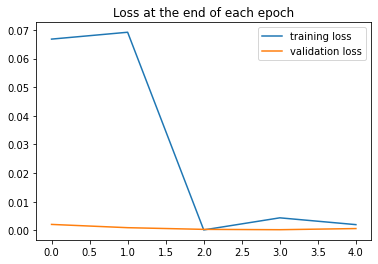

In [13]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

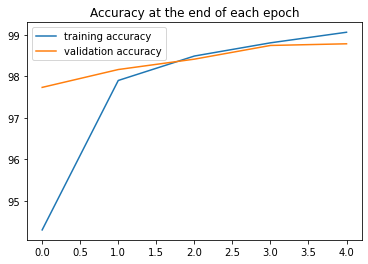

In [14]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [15]:
#NEW UNSEEN IMAGES
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test) 
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9878/10000 =  98.780%
